# 당뇨병 예측 프로그램

**환경설정(데이터 불러오기 + 라이브러리)**

In [68]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay


In [70]:
# 매트릭스 형태 구성
diabetes = pd.read_csv("diabetes.csv", encoding="utf-8")
print(diabetes.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [71]:
# 한글 깨짐 방지
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

#### EDA

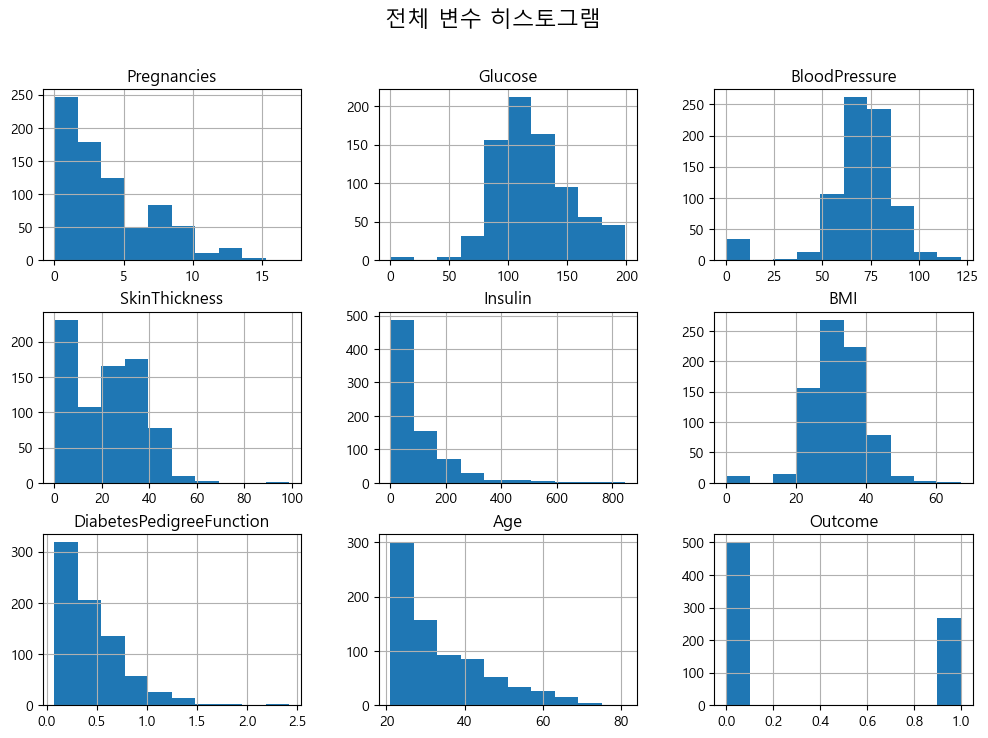

In [72]:
diabetes.hist(figsize=(12,8))
plt.suptitle("전체 변수 히스토그램",fontsize=16)
plt.show()

<Axes: >

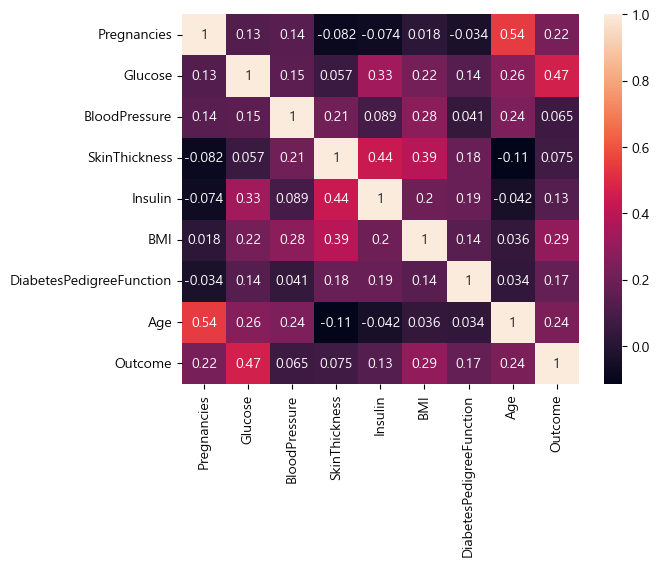

In [73]:
corr_d = diabetes.corr()
sns.heatmap(corr_d, annot = True)


**상관분석**

- 당뇨 예측에서 가장 중요한 변수는 Glucose로 예상됨 (outcome과의 상관관계만 파악했을 때)
- 특징 간 관계에서는 Pregnancies–Age와 SkinThickness–Insulin이
대표적 상관 관계로 보여짐.

**결측치 + 오류값 분석**

(1) 오류값 제외버전

In [74]:
# 1) 0값(생리학적으로 불가능한 값) 개수 확인
zero_counts = (diabetes == 0).sum()
print(f"생리적으로 불가능한 0 값 개수:{zero_counts}")

생리적으로 불가능한 0 값 개수:Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [75]:
# 2) 원본 결측치(NaN) 개수 확인 ---
na_counts_before = diabetes.isnull().sum()
print("원본 NaN(결측치) 개수:")
print(na_counts_before)

원본 NaN(결측치) 개수:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [76]:
# 1) 0값(생리학적으로 불가능한 값) 개수 확인
zero_counts = (diabetes == 0).sum()
print(f"생리적으로 불가능한 0 값 개수:{zero_counts}")

생리적으로 불가능한 0 값 개수:Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [77]:
# 생리학적으로 불가능한 값 → NaN 변환
for col in ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]:
    diabetes[col] = diabetes[col].replace(0, np.nan)

# 중앙값으로 결측치 대체
diabetes = diabetes.fillna(diabetes.median())

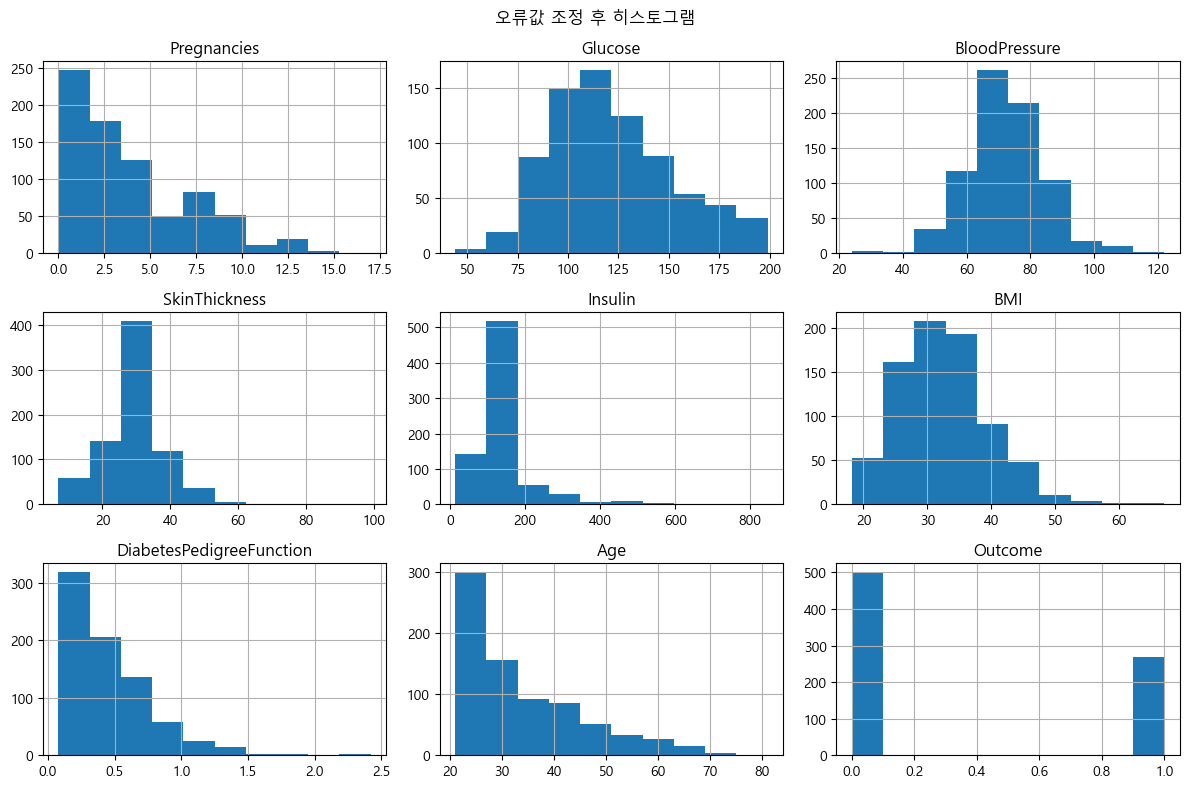

In [78]:
diabetes.hist(figsize=(12,8))
plt.suptitle("오류값 조정 후 히스토그램")
plt.tight_layout()
plt.show()

In [79]:
gl = diabetes["Glucose"]
diabetes["InsulinGlucoseRatio"] = (diabetes["Insulin"] / gl).fillna(0)
diabetes["Insulin_log"] = np.log1p(diabetes["Insulin"])

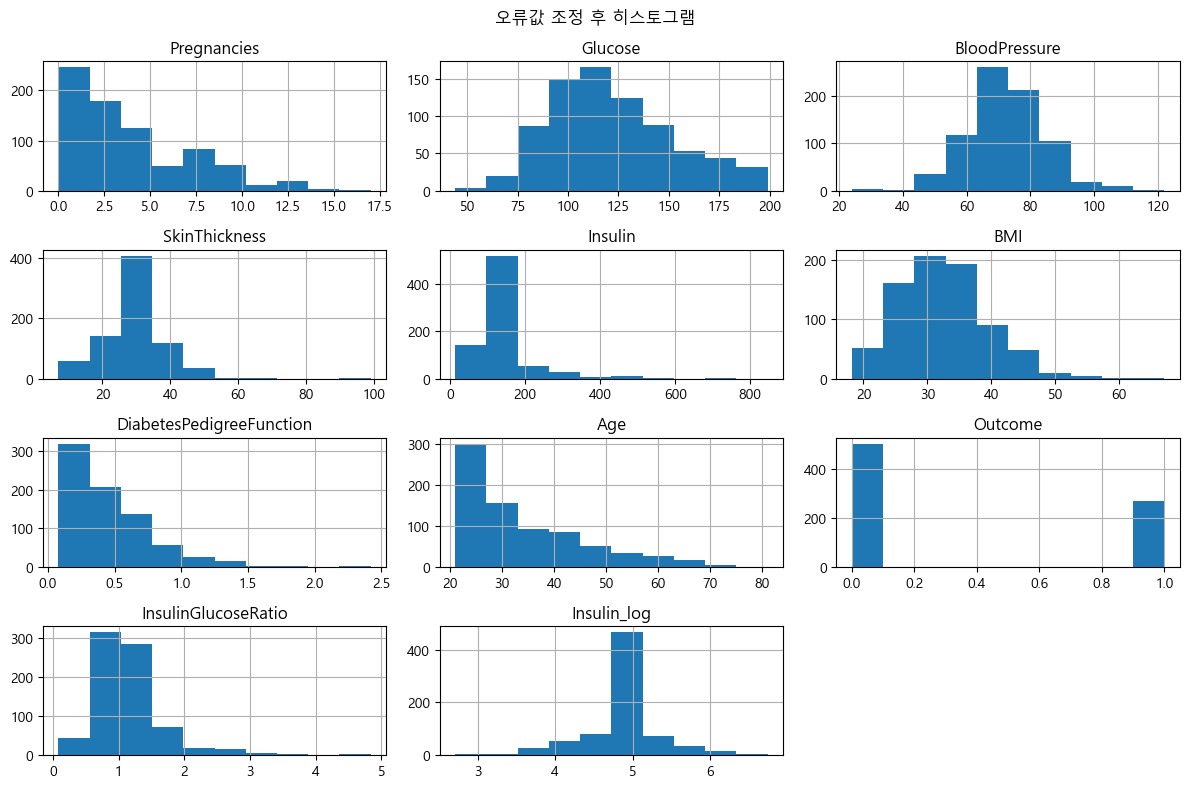

In [80]:
diabetes.hist(figsize=(12,8))
plt.suptitle("오류값 조정 후 히스토그램")
plt.tight_layout()
plt.show()

#### 훈련- 테스트 데이터 분할

In [81]:
X = diabetes.drop("Outcome", axis=1)
y = diabetes["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [82]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)


In [83]:
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train_s, y_train)

knn_pred = knn.predict(X_test_s)
knn_acc = accuracy_score(y_test, knn_pred)


In [84]:
from sklearn.linear_model import LogisticRegression

logi = LogisticRegression(max_iter=1000)
logi.fit(X_train, y_train)
logi_pred = logi.predict(X_test)
logi_acc=accuracy_score(y_test, logi_pred)


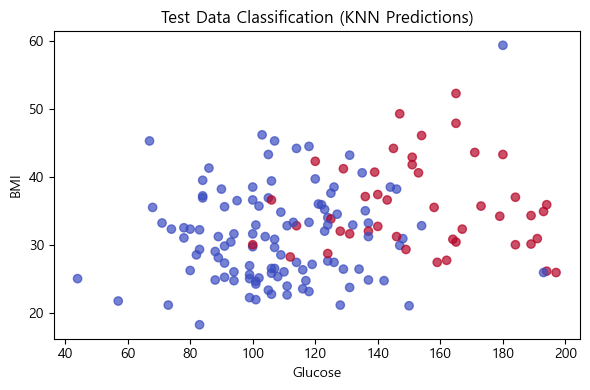

In [85]:
plt.figure(figsize=(6,4))

plt.scatter(
    X_test["Glucose"],
    X_test["BMI"],
    c=knn_pred,
    cmap="coolwarm",
    alpha=0.7
)

plt.xlabel("Glucose")
plt.ylabel("BMI")
plt.title("Test Data Classification (KNN Predictions)")
plt.tight_layout()
plt.show()


In [86]:
perf = pd.DataFrame({
    "Model": ["KNN (k=21)","Linear Regression"],
    "Accuracy": [knn_acc, logi_acc]
})

perf


,Model,Accuracy
0,KNN (k=21),0.759740
1,Linear Regression,0.694805
